In [1]:
# some setup code
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
from time import time

# A bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline 
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/seo/anaconda3/envs/cnnPy3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


function to load data (RGB)

file structure:

```sh
NeuralNetwork_RGB.ipynb
./data:
    labels.csv
    posts_filtered.csv
    rgbdata50.csv
```


In [151]:
def load_data():
    start = time()

    print('Getting 4096 features')
    f4096 = np.loadtxt('data/4096features_3.csv', delimiter=',', dtype=np.float32)
    f4096.shape = (-1, 4096)

    print('Job completed in: {} seconds'.format(time()-start))
    return f4096

f4096_tmp = load_data()
print('f4096 shape', f4096_tmp.shape)
print('labels shape', labels_tmp.shape)

Getting labels
Getting 4096 features
Job completed in: 60.52671694755554 seconds
f4096 shape (15000, 4096)
labels shape (15000, 1)


In [ ]:
def load_labels():
    print('Getting labels')
    labels = np.loadtxt('data/labels_3_lin.csv', delimiter=',', dtype=np.float32)
    labels = np.minimum(1.0, labels)
    data_size = labels.shape[0]
    labels.shape = (-1,1)
    return labels

labels_tmp = load_labels()

In [31]:
def load_img():
    print('Getting RGB data')
    rgb = np.loadtxt('data/rgbdata50_3.csv', delimiter=',', dtype=np.float32)
    rgb.shape = (-1, 3, 50, 50)
#     rgb = np.mean(rgb, axis=1)
    return rgb

rgb_tmp = load_img()

Getting RGB data


In [3]:
### SKIP SKIP SKIP ###
### Remove datapoints that are less than a threshold. 
### Tried this because the data seemed to be very skewed near zero
### But removing datapoints makes correlation less
def preprocess(f4096, labels):
    f4096 = f4096.tolist()
    labels = labels.tolist()
    i = 0
    while i < len(labels):
        label = labels[i][0]
        if label < 10**(-1.7):
            labels.pop(i)
            f4096.pop(i)
        else:
            i += 1
    return np.reshape(np.array(f4096), (-1, 4096)), np.reshape(np.array(labels), (-1, 1))

f4096, labels = preprocess(f4096_tmp, labels_tmp)
print('f4096 shape', f4096.shape)
print('labels shape', labels.shape)

f4096 shape (10888, 4096)
labels shape (10888, 1)


In [3]:
f4096, labels = (f4096_tmp, labels_tmp)
print(f4096.shape)

(15000, 4096)


In [152]:
def divide_data(rgb, f4096, labels, data_size=None, train_ratio=0.9):
    '''Randomly select given number of data and divide into training set and test set'''
    data_size_max = labels.shape[0]
    data_size = data_size_max if data_size is None else data_size
    train_size = int(np.floor(train_ratio * data_size))
    test_size = data_size - train_size

    mask = list(range(data_size_max))
    mask = np.random.choice(mask, data_size, replace=False)
    rgb = rgb[mask]/255
    f4096 = f4096[mask]/255
    labels = np.minimum(labels[mask], 1.0)
    
    rgb_train = rgb[:train_size]
    X_train = f4096[:train_size]
    y_train = labels[:train_size]
    
    rgb_test = rgb[train_size:]
    X_test = f4096[train_size:]
    y_test = labels[train_size:]

    return (rgb_train, X_train, y_train), (rgb_test, X_test, y_test)

(rgb_train, X_train, y_train), (rgb_test, X_test, y_test) = divide_data(rgb_tmp, f4096_tmp, labels_tmp, 
#                                                    data_size=1000, 
                                                   train_ratio=10/11) # 10/11 this ratio allows train = 10*test
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('X_train', X_train[:2])
print('y_train', y_train[:2])

X_train shape: (13636, 4096)
X_test shape: (1364, 4096)
X_train [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
y_train [[ 0.02093718]
 [ 0.00367109]]


In [148]:
y_test = (1+np.log10(np.maximum(10**-4, y_test))/4)/10000
y_train = (1+np.log10(np.maximum(10**-4, y_train))/4)/10000

In [138]:
### SKIP SKIP SKIP ###
### Model building function for convolutional approach.
### Using CNN for 4096 features is senseless.
def buildModel(shape):
    model = Sequential()
    print(shape)
    model.add(Conv2D(32, (3, 3),
                     padding='same',
                     activation='relu',
                     data_format="channels_first",
                     input_shape=shape))
    model.add(Conv2D(32, (3, 3),
                     data_format="channels_first",
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (4, 4),
                     data_format="channels_first",
                     activation='relu'))
    model.add(Conv2D(32, (3, 3),
                     data_format="channels_first",
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, 
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                    activation='relu'))
    
    rmsprop = RMSprop(lr=0.00005, rho=0.9, epsilon=1e-08, decay=0.0)
    sgd = SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)
    def abs_diff(y_true, y_pred):
        return np.absolute(y_true - y_pred)
    model.compile(optimizer=rmsprop,
                  loss='mse',
                  metrics=[abs_diff, 'mse'])

    return model

X_train.shape = (-1, 1, 64, 64)
X_test.shape = (-1, 1, 64, 64)
input_shape = X_train.shape[1:]
# input_shape = (1, 64, 64)
model = buildModel(input_shape)
print(model)


(1, 64, 64)


In [153]:
def buildModel_dense(shape):
    model = Sequential()
    print(shape)
    model.add(Dense(1024,
                     activation='relu',
                     input_shape=shape))
    model.add(Dropout(0.25))
    model.add(Dense(512,
                   activation='relu'))

    model.add(Dense(128,
                   activation='relu'))
    model.add(Dense(64,
                   activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32,
                   activation='relu'))
    model.add(Dense(16,
                   activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                   activation='sigmoid'))
    
    rmsprop = RMSprop(lr=0.00005, rho=0.9, epsilon=1e-08, decay=0.0)
    sgd = SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)
    def abs_diff(y_true, y_pred):
        return np.absolute(y_true - y_pred)
    model.compile(optimizer=rmsprop,
                  loss='mse',
                  metrics=[abs_diff, 'mse'])

    return model

X_train.shape = (-1, 4096)
X_test.shape = (-1, 4096)
input_shape = X_train.shape[1:]
# input_shape = (1, 64, 64)
model = buildModel_dense(input_shape)
print(model)


(4096,)


In [87]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(13636, 4096) (1364, 4096) (13636, 1) (1364,)


In [154]:
from keras.callbacks import TensorBoard

hist = model.fit(X_train, y_train,
                batch_size=128, 
                epochs=2,
                verbose=1,
                validation_data=(X_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
          
score = model.evaluate(X_test, y_test)


print('Validation loss:', round(score[0],2))
print('Validation accuracy:', round(100*score[1],2), "%")

Train on 13636 samples, validate on 1364 samples
Epoch 1/2
13636/13636 [==============================] - 9s - loss: 0.0623 - abs_diff: 0.2012 - mean_squared_error: 0.0623 - val_loss: 0.0157 - val_abs_diff: 0.0708 - val_mean_squared_error: 0.0157
Epoch 2/2
1120/1364 [=======================>......] - ETA: 0sValidation loss: 0.02
Validation accuracy: 7.34 %


In [29]:
print(keras.__version__)
x = np.array([1,23,4,5,6,6,423,2])
print(np.minimum(1, 4.5))
print(model.metrics_names)

2.0.4
1.0
['loss', 'acc']


### Plot Predicted values vs Real values

There are almost no correlation between RGB and lables

In [155]:
y_prediction = model.predict(X_test, verbose=1)

#y_test = y_test

1152/1364 [========================>.....] - ETA: 0s

(1364,)
[ 0.01929379  0.16783217  0.082984    0.09485095  0.0358501   0.12646745
  0.00583435  0.05798421  0.33333334  0.01274833]
[ 0.00703388  0.04288812  0.02704903  0.06492528  0.02924722  0.003762
  0.02134397  0.0125332   0.00943483  0.03966899]


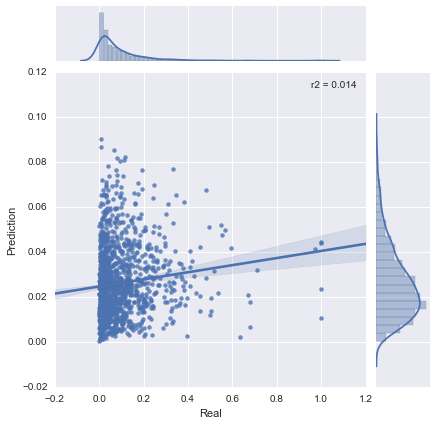

In [156]:
from scipy import stats

y_test.shape = (-1)
y_prediction.shape = (-1)
print(y_test.shape)
print(y_test[0:10])
print(y_prediction[0:10])
data = np.array([y_prediction, y_test]).T
# data.shape = (2, -1)
# plt.title('CNN on RGB of Dataset#1')
df = pd.DataFrame(data, columns=["Prediction", "Real"])
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.jointplot(x="Real", y="Prediction", data=df, kind='reg', stat_func=r2);

In [157]:
pred_med, pred_mean = np.median(y_prediction), np.mean(y_prediction)
true_med, true_mean = np.median(y_test), np.mean(y_test)

print('Prediction \tMedian {} \tMean {}'.format(pred_med, pred_mean))
print('True \t\tMedian {} \tMean {}'.format(true_med, true_mean))

# print(np.median(y_test))

Prediction 	Median 0.023014739155769348 	Mean 0.025977905839681625
True 		Median 0.04848504811525345 	Mean 0.08976228535175323


[1101 1117  489 1036  626  106  124  975  327  353  850  765  204  865  629
  547  723 1259  254  561  659  177 1011 1118 1299 1219  246 1197  945  745
  669  283  939  981 1240 1248   77 1035  322   72  442  233  851  649 1361
 1134 1070  305  867  863]


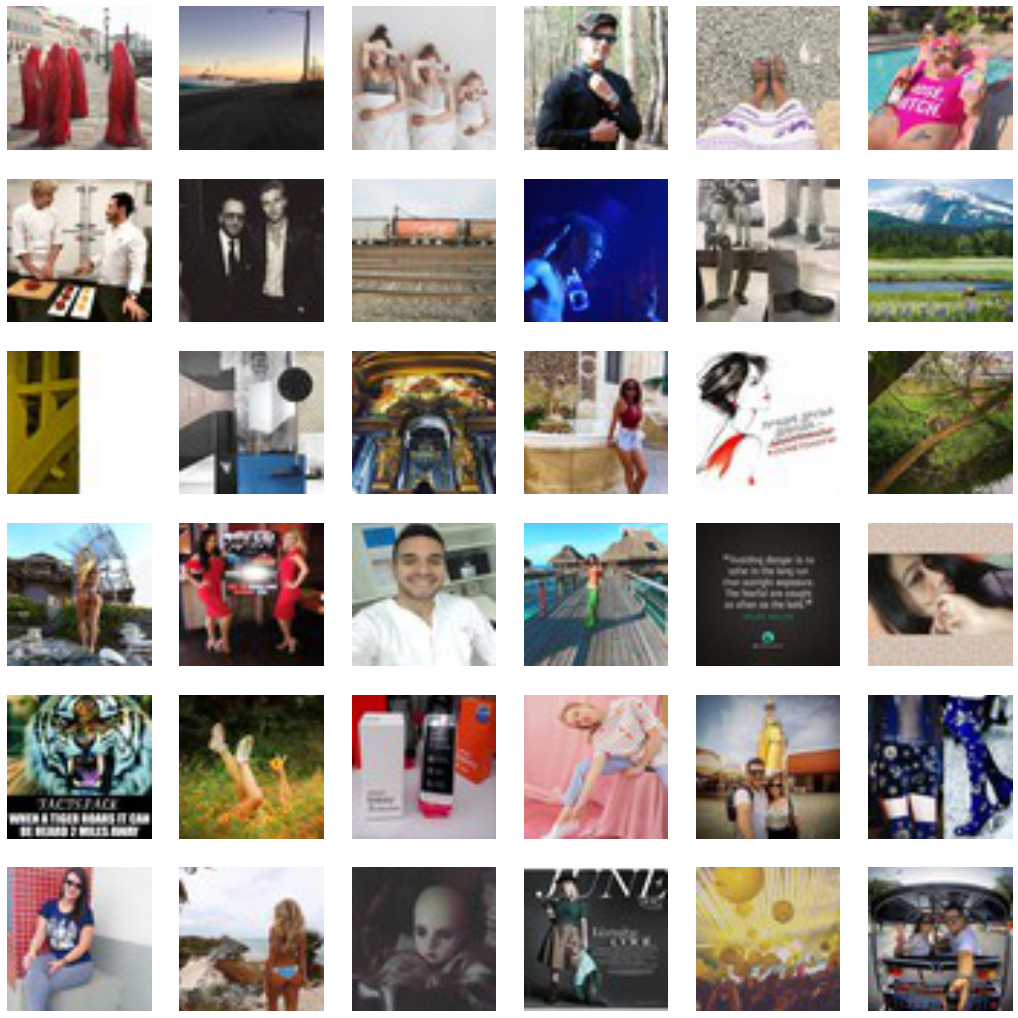

In [158]:
import matplotlib.pyplot as plt
###Display some images

n = y_test.shape[0]
mask = list(range(y_test.shape[0]))
mask = np.random.choice(mask, n, replace=False)
# print(mask)

img_count = [[0, 0],
            [0, 0]]
r = 6
c = 6

def display(idx):
    img = rgb_test[idx]
    img.shape = (3, 50, 50)
    img.shape = (3, 2500)
    img = img.T
    img.shape = (50, 50, 3)

    x_pos = y_test[idx] - true_med
    y_pos = y_prediction[idx] - pred_med
    if np.absolute(x_pos) < 10**-1.5:
        return
    
    if y_pos > 0:
        if x_pos > 0:
            pos = img_count[0][1]
            if pos >= r*c/4:
                return
            img_count[0][1] += 1
            row = pos // (c/2)
            col = pos % (c/2) + 1
            ax = plt.subplot(r, c, row*c + c/2+col)
        else:
            pos = img_count[0][0]
            if pos >= r*c/4:
                return
            img_count[0][0] += 1
            row = pos // (c/2)
            col = pos % (c/2) + 1
            ax = plt.subplot(r, c, row*c + col)
    else:
        if x_pos > 0:
            pos = img_count[1][1]
            if pos >= r*c/4:
                return
            img_count[1][1] += 1
            row = pos // (c/2)
            col = pos % (c/2) + 1
            ax = plt.subplot(r, c, (row+r/2)*c + c/2+col)
        else:
            pos = img_count[1][0]
            if pos >= r*c/4:
                return
            img_count[1][0] += 1
            row = pos // (c/2)
            col = pos % (c/2) + 1
            ax = plt.subplot(r, c, (row+r/2)*c + col)
            
    plt.imshow(img)
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.figure(figsize=(c*3, r*3))
for i in range(n):
    idx = mask[i]
    display(idx)
plt.show()

/Users/seo/anaconda3/envs/cnnPy3/lib/python3.4/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


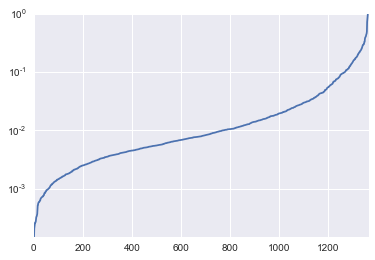

In [111]:
l = y_test.shape[0]
plt.figure()
plt.plot(list(range(l)), np.sort(y_test))
plt.yscale('log')
plt.axis((0,l,0,1))
plt.show()

In [92]:
lab = [1,3,543,6,3,547,45]
print(np.minimum(1.0, lab))

[ 1.  1.  1.  1.  1.  1.  1.]


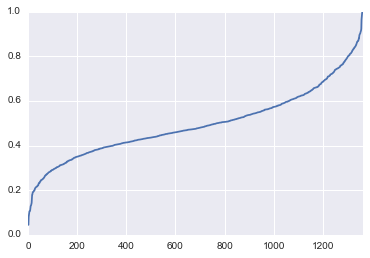

In [126]:
l = y_test.shape[0]
plt.figure()
plt.plot(list(range(l)), np.sort(np.maximum(-4, 1+np.log10(y_test)/4)))
# plt.yscale('log')
plt.axis((0,l,0,1))
plt.show()


In [127]:
y_test = np.maximum(0, 1+np.log10(y_test)/4)
y_train = np.maximum(0, 1+np.log10(y_train)/4)

/Users/seo/anaconda3/envs/cnnPy3/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
